# A. Libraries

In [1]:
!pip install findspark
!pip install nltk
!pip install -U deep-translator
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

     |████████████████████████████████| 128 kB 5.7 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
--2022-04-30 13:39:06--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2022-04-30 13:39:06--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2022-04-30 13:39:07--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nl

In [243]:
import copy
import findspark
import keras
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import sparknlp
import string

from collections import Counter

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import SVC

from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
from sparknlp.pretrained import ResourceDownloader

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

In [3]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# B. Dataset

In [134]:
column = ['tweet', 'sentiment']

In [135]:
def get_data(link):
    # read file from given link
    temp = pd.read_json(link, orient = "index")

    # remove unnecessary column
    temp = temp[column]

    # drop rows with null values
    temp = temp.dropna()

    # typecast sentiment as int (by default it is float)
    temp['sentiment'] = temp['sentiment'].astype(int)

    # select only data with sentiment = 1 or -1
    temp = temp.loc[(temp['sentiment'] == 1) | (temp['sentiment'] == -1)]
    temp.reset_index(drop = True, inplace = True)

    return temp

In [136]:
df = get_data("https://raw.githubusercontent.com/VinsenN/Sentiment-Analysis-Pemindahan-Ibu-Kota/main/data/IKN.json")
df.head()

,tweet,sentiment
0,"@jokowi saya sangat setuju pak, bahkan lebih s...",1
1,@hnurwahid @FPKSDPRRI Saya setuju ibu kota pin...,1
2,@MardaniAliSera @FPKSDPRRI Saya dan mayoritas ...,1
3,cocok ibu kota pindah ke kalimantan apalagi gu...,1
4,"@geedeulbeyou1 Jadi, kepada lo yang gak setuju...",1


<Figure size 1440x1080 with 0 Axes>

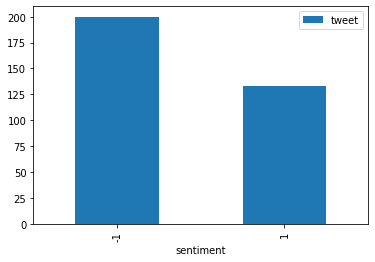

In [138]:
fig = plt.figure(figsize = (20, 15))
df.groupby('sentiment').count().plot.bar()

# C. Preprocess - Basic

In [140]:
# harga     emas      -> harga emas
def remove_redundant_space(text):
    # trailing spaces
    text = re.sub(" +$", "", text)
    # leading spaces
    text = re.sub("^ +", "", text)
    # redundant spaces
    text = re.sub(" +", " ", text)
    return text

In [141]:
def remove_mention(text):
    return re.sub("@\S+", " ", text)

In [142]:
def remove_hashtag(text):
    return re.sub("#\S+", " ", text)

In [143]:
# emojis, dll
def remove_special_char(text):
    return re.sub(r"[^a-zA-z0-9.,!?/:;\"\'\s]" , " ", text)

In [144]:
def remove_num(text):
    return re.sub(r"\d+", " ", text)

In [145]:
# hello! -> hello
def remove_punctuation(text):
    text = re.sub("_", " ", text)
    text = re.sub("_+", " ", text)
    text = re.sub(r"[^\w\s]", " ", text)
    return text;

In [146]:
def preprocess_basic(text):
    text = remove_mention(text)
    text = remove_hashtag(text)
    text = remove_special_char(text)
    text = remove_punctuation(text)
    text = remove_num(text)
    text = text.lower()
    text = remove_redundant_space(text)
    return text

In [147]:
testing_text = "       !\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~ HALO   🤣   Halo123 Halo     123 halo 😪😪😪😪 (Test) #IKN #Ibu_Kota_Negara @Vinsen_Nawir @Emmanuel_Henry     "
print(preprocess_basic(testing_text))

halo halo halo halo test


# D. Preprocess - More

### Remove insignificant words

We define insignificant words as the word that has less occurence than a predefined threshold.

In [148]:
def remove_noise(text: str, 
                 freq: Counter, 
                 threshold: int):
    
    text = " ".join([word for word in text.split()
                     if freq[word] >= threshold])
    return remove_redundant_space(text)

### Remove slangs and abbreviations

In [149]:
dict1 = pd.read_csv("https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv", encoding = "ISO-8859-1")
dict2 = pd.read_csv("https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv")
dict3 = pd.read_csv("https://raw.githubusercontent.com/VinsenN/Sentiment-Analysis-Pemindahan-Ibu-Kota/main/data/slang/custom-slang.csv")

In [150]:
columns = ['slang', 'formal']
dict1.columns = columns
dict2 = dict2[columns]
dict3.columns = columns

# Combine all dictionaries
dict1 = dict1.append(dict2)
dict1 = dict1.append(dict3)

# Remove duplicate values
dict1.sort_values('slang', inplace = True)
dict1.drop_duplicates(subset = columns, keep = False, inplace = True)

# Convert into python dict
kata_gaul = pd.Series(dict1['formal'].values, index = dict1['slang']).to_dict()

In [151]:
def normalize_slang(text):
    return " ".join([kata_gaul[word] if word in kata_gaul
                     else word
                     for word in text.split(' ')])

### Remove stopwords

In [152]:
# Creating stopword dictionary
stopword_list = stopwords.words('indonesian')
whitelist = ['tidak', 'bukan', 'enggak', 'daripada', 'melainkan']
blacklist = ['jokowi', 'joko', 'widodo', 'ahok', 'rocky', 'gerung', 'pks', 'partai', 'keadilan', 'sejahtera', 'oligarki', 'kalimantan', 'jawa', 'jakarta', 'jkt', 'papua']

for word in whitelist:
    stopword_list.remove(word)

for word in blacklist:
    stopword_list.append(word)

In [153]:
def remove_stopword(text):
    text = ' '.join([word if word not in stopword_list
                     else ""
                     for word in text.split(' ')])
    return remove_redundant_space(text)

In [154]:
testing_text = "sebagai presiden indonesia saya tidak setuju dengan pernyataan anda"
print(remove_stopword(testing_text))

presiden indonesia tidak setuju pernyataan


### Lemmatization

In [155]:
findspark.init()
spark = sparknlp.start()
print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

Spark NLP version:  3.4.3
Apache Spark version:  3.0.3


In [156]:
# Create pipeline according to demo as shown below
# https://nlp.johnsnowlabs.com/2022/03/31/lemma_csui_id_3_0.html

document = DocumentAssembler().setInputCol("text").setOutputCol("document")
sentence = SentenceDetectorDLModel.pretrained("sentence_detector_dl", "xx").setInputCols(["document"]).setOutputCol("sentence")
tokenizer = Tokenizer().setInputCols(["sentence"]).setOutputCol("token")
lemma = LemmatizerModel.pretrained("lemma_csui", "id").setInputCols(["sentence", "token"]).setOutputCol("lemma")
pipeline = Pipeline(stages=[document, sentence, tokenizer, lemma])

sentence_detector_dl download started this may take some time.
Approximate size to download 514.9 KB
[OK!]
lemma_csui download started this may take some time.
Approximate size to download 85.5 KB
[OK!]


In [157]:
def lemmatize(txt):
    data = spark.createDataFrame([[txt]]).toDF("text")
    result = pipeline.fit(data).transform(data)

    lemma_stc = []
    for x in result.head().lemma[1:]:
        lemma_stc.append(x.result)
    return (" ".join(lemma_stc))

In [158]:
testing_text = "presiden indonesia joko widodo melakukan pengesahan persetujuan pernyataan pemindahan ibu kota negara"
print(lemmatize(testing_text))

presiden indonesia joko widodo laku pengesahan setuju pernyataan pemindahan ibu kota negara


### Combining all preprocessing methods

In [159]:
def preprocess_advanced(text: str,
                        freq: Counter,
                        threshold: int):
    text = remove_noise(text, freq, threshold)
    text = normalize_slang(text)
    text = remove_stopword(text)
    text = lemmatize(text)
    return text

In [160]:
def count_frequency(data: pd.DataFrame):
        # generate word frequency table
        word_list = []
        for tweet in data['tweet']:
            for word in tweet.split():
                word_list.append(word)
        
        return Counter(word_list)

In [161]:
def preprocess(data: pd.DataFrame, threshold: int):
    clean = copy.deepcopy(data)
    counter = count_frequency(clean)
    clean['tweet'] = clean['tweet'].apply(preprocess_basic)
    clean['tweet'] = clean['tweet'].apply(preprocess_advanced, args =  (counter, threshold))
    return clean

# E. Model

In [162]:
dataset = preprocess(df, 5)
#dataset_10 = preprocess(df, 10)

In [163]:
def get_w2v_arr(tokenized_x, **kwargs):
    w2v_model = Word2Vec(
                    tokenized_x, 
                    size = kwargs['size'], 
                    min_count = kwargs['min_count'], 
                    window = kwargs['window'], 
                    workers = 4, 
                    sg = 1, 
                    alpha = 0.01, 
                    min_alpha = 0.0001, 
                    seed = 777
                )

    res = np.zeros((len(tokenized_x), kwargs['size']))
    for i in range(len(tokenized_x)):
        for word in tokenized_x[i]:
            try:
                res[i] += w2v_model[word]
            except KeyError:
                continue

    if kwargs['scaling'] == 1:
        res = MinMaxScaler().fit_transform(res)
    return res

In [164]:
def get_d2v_arr(tokenized_x, **kwargs):
    d2v_model = Doc2Vec(
                    size = kwargs['size'], 
                    alpha = kwargs['alpha'], 
                    min_alpha = 0.00025, 
                    min_count = 1, 
                    dm = 1
                )
    d2v_model.build_vocab(tokenized_x)

    for epoch in range(kwargs['max_epochs']):
        d2v_model.train(tokenized_x, total_examples = d2v_model.corpus_count, epochs=d2v_model.iter)
        d2v_model.alpha -= 0.0002 # decrease the learning rate
        d2v_model.min_alpha = d2v_model.alpha # fix the learning rate, no decay
    
    res = np.zeros((len(tokenized_x), kwargs['size']))
    for i in range(len(tokenized_x)):
        res[i] = d2v_model.docvecs[i]
    
    if kwargs['scaling'] == 1:
        res = MinMaxScaler().fit_transform(x_d2v)
    return res

In [265]:
class LSTM_Model:
    def __init__(self,
                 data: pd.DataFrame,
                 split: float,
                 feature: str,
                 **kwargs):
        
        # initialize parameter
        self.data = data
        self.split = split
        self.feature = feature
        self.kwargs = kwargs
        
        # separate features and label
        self.x = self.data['tweet']
        self.y = self.data['sentiment']

        # feature extraction
        self.x_train, self.x_test, self.y_train, self.y_test = self._create_feature()

        # create model
        self._create_model()

    def _create_feature(self):
        lb=LabelEncoder()
        self.y = lb.fit_transform(self.y)

        if self.feature == "ttseq":
            data_temp = copy.deepcopy(self.data)
            tokenizer = keras.preprocessing.text.Tokenizer(num_words = 100, split = ' ')
            tokenizer.fit_on_texts(self.x)

            self.x = tokenizer.texts_to_sequences(data_temp['tweet'].values)
            self.x = pad_sequences(self.x)

            x_train, x_test, y_train, y_test = train_test_split(
                                                    self.x, self.y, 
                                                    test_size = self.split,
                                                    random_state = 777, # lucky number
                                                    stratify = y
                                               )
            
        elif self.feature == "w2v":
            w2v_param = {
                'size': 100,
                'min_count': 2,
                'window': 1,
                'scaling': 0
            }

            if 'w2v_param' in self.kwargs:
                w2v_param = self.kwargs['w2v_param']

            x_token = self.x.apply(word_tokenize)
            x_token = x_token.reset_index(drop = True)

            self.x = get_w2v_arr(x_token, **w2v_param)

            x_train, x_test, y_train, y_test = train_test_split(
                                                    self.x, self.y, 
                                                    test_size = self.split,
                                                    random_state = 777, # lucky number
                                                    stratify = y
                                               )
        
        elif self.feature == "d2v":
            d2v_param = {
                'size': 100,
                'max_epochs': 20,
                'alpha': 0.025,
                'scaling': 0
            }

            if 'd2v_param' in self.kwargs:
                w2v_param = self.kwargs['w2v_param']
            
            x_tag_token = [TaggedDocument(words=word_tokenize(w), tags=[str(i)]) for i, w in enumerate(self.x)]
            self.x = get_d2v_arr(x_tag_token, **d2v_param)

            x_train, x_test, y_train, y_test = train_test_split(
                                                    self.x, self.y, 
                                                    test_size = self.split,
                                                    random_state = 777, # lucky number
                                                    stratify = y
                                               )     

        return [x_train, x_test, y_train, y_test]
    
    def _create_model(self):
        model = Sequential()
        model.add(Embedding(input_dim = 200, output_dim = self.x.shape[1], input_length = self.x.shape[1]))
        model.add(SpatialDropout1D(0.4))
        model.add(LSTM(500, dropout = 0.2, recurrent_dropout = 0.2))
        model.add(Dense(2, activation = 'softmax'))
        model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        print(model.summary())

        self.model = model

    def train_model(self):
        self.model.fit(self.x_train, self.y_train, epochs = 25, batch_size = 64, verbose = 'auto')

    def evaluate_model(self):
        y_pred = self.model.predict(self.x_train, batch_size = 64, verbose = 'auto')
        y_pred = np.argmax(y_pred, axis = 1)
        print("\nTraining Dataset")
        print("=====================================================")
        print(f"accuracy score  : {accuracy_score(self.y_train, y_pred) * 100}")
        print(f"precision score : {precision_score(self.y_train, y_pred, average = 'macro') * 100}")
        print(f"recall score    : {recall_score(self.y_train, y_pred, average = 'macro') * 100}")
        print(f"f1-score        : {f1_score(self.y_train, y_pred, average = 'macro') * 100}")

        y_pred = self.model.predict(self.x_test, batch_size = 64, verbose = 'auto')
        y_pred = np.argmax(y_pred, axis = 1)
        print("\nTesting Dataset")
        print("=====================================================")
        print(f"accuracy score  : {accuracy_score(self.y_test, y_pred) * 100}")
        print(f"precision score : {precision_score(self.y_test, y_pred, average = 'macro') * 100}")
        print(f"recall score    : {recall_score(self.y_test, y_pred, average = 'macro') * 100}")
        print(f"f1-score        : {f1_score(self.y_test, y_pred, average = 'macro') * 100}")
        print("\n")

### LSTM + Text To Sequence

In [266]:
model = LSTM_Model(dataset, 0.2, "ttseq")

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 22, 22)            4400      
                                                                 
 spatial_dropout1d_38 (Spati  (None, 22, 22)           0         
 alDropout1D)                                                    
                                                                 
 lstm_38 (LSTM)              (None, 500)               1046000   
                                                                 
 dense_38 (Dense)            (None, 2)                 1002      
                                                                 
Total params: 1,051,402
Trainable params: 1,051,402
Non-trainable params: 0
_________________________________________________________________
None


In [267]:
model.train_model()

Epoch 1/25
5/5 [==============================] - 6s 601ms/step - loss: 0.6873 - accuracy: 0.5902
Epoch 2/25
5/5 [==============================] - 3s 593ms/step - loss: 0.6763 - accuracy: 0.6015
Epoch 3/25
5/5 [==============================] - 3s 591ms/step - loss: 0.6766 - accuracy: 0.6015
Epoch 4/25
5/5 [==============================] - 3s 584ms/step - loss: 0.6700 - accuracy: 0.6015
Epoch 5/25
5/5 [==============================] - 3s 587ms/step - loss: 0.6559 - accuracy: 0.6015
Epoch 6/25
5/5 [==============================] - 3s 590ms/step - loss: 0.6494 - accuracy: 0.6015
Epoch 7/25
5/5 [==============================] - 3s 601ms/step - loss: 0.6357 - accuracy: 0.6654
Epoch 8/25
5/5 [==============================] - 3s 609ms/step - loss: 0.6277 - accuracy: 0.6992
Epoch 9/25
5/5 [==============================] - 3s 599ms/step - loss: 0.5997 - accuracy: 0.6466
Epoch 10/25
5/5 [==============================] - 3s 603ms/step - loss: 0.5661 - accuracy: 0.6617
Epoch 11/25
5/5 [==

In [268]:
model.evaluate_model()


Training Dataset
accuracy score  : 83.0827067669173
precision score : 82.43089199202052
recall score    : 83.5495283018868
f1-score        : 82.71105654654438

Testing Dataset
accuracy score  : 79.1044776119403
precision score : 78.96613190730838
recall score    : 80.0925925925926
f1-score        : 78.87387387387388




### LSTM + Word2Vec

In [269]:
model = LSTM_Model(dataset, 0.2, "w2v")

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 100, 100)          20000     
                                                                 
 spatial_dropout1d_39 (Spati  (None, 100, 100)         0         
 alDropout1D)                                                    
                                                                 
 lstm_39 (LSTM)              (None, 500)               1202000   
                                                                 
 dense_39 (Dense)            (None, 2)                 1002      
                                                                 
Total params: 1,223,002
Trainable params: 1,223,002
Non-trainable params: 0
_________________________________________________________________
None


In [270]:
model.train_model()

Epoch 1/25
5/5 [==============================] - 20s 3s/step - loss: 0.6791 - accuracy: 0.5865
Epoch 2/25
5/5 [==============================] - 15s 3s/step - loss: 0.6723 - accuracy: 0.6015
Epoch 3/25
5/5 [==============================] - 15s 3s/step - loss: 0.6757 - accuracy: 0.6015
Epoch 4/25
5/5 [==============================] - 15s 3s/step - loss: 0.6777 - accuracy: 0.6015
Epoch 5/25
5/5 [==============================] - 15s 3s/step - loss: 0.6736 - accuracy: 0.6015
Epoch 6/25
5/5 [==============================] - 15s 3s/step - loss: 0.6777 - accuracy: 0.6015
Epoch 7/25
5/5 [==============================] - 15s 3s/step - loss: 0.6750 - accuracy: 0.6015
Epoch 8/25
5/5 [==============================] - 15s 3s/step - loss: 0.6749 - accuracy: 0.6015
Epoch 9/25
5/5 [==============================] - 15s 3s/step - loss: 0.6717 - accuracy: 0.6015
Epoch 10/25
5/5 [==============================] - 15s 3s/step - loss: 0.6818 - accuracy: 0.6015
Epoch 11/25
5/5 [======================

In [272]:
model.evaluate_model()


Training Dataset
accuracy score  : 60.150375939849624
precision score : 30.075187969924812
recall score    : 50.0
f1-score        : 37.558685446009385

Testing Dataset
accuracy score  : 59.70149253731343
precision score : 29.850746268656714
recall score    : 50.0
f1-score        : 37.38317757009346




### LSTM + Doc2Vec

In [273]:
model = LSTM_Model(dataset, 0.2, "d2v")

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 100, 100)          20000     
                                                                 
 spatial_dropout1d_40 (Spati  (None, 100, 100)         0         
 alDropout1D)                                                    
                                                                 
 lstm_40 (LSTM)              (None, 500)               1202000   
                                                                 
 dense_40 (Dense)            (None, 2)                 1002      
                                                                 
Total params: 1,223,002
Trainable params: 1,223,002
Non-trainable params: 0
_________________________________________________________________
None


In [274]:
model.train_model()

Epoch 1/25
5/5 [==============================] - 21s 3s/step - loss: 0.6779 - accuracy: 0.5827
Epoch 2/25
5/5 [==============================] - 15s 3s/step - loss: 0.6789 - accuracy: 0.6015
Epoch 3/25
5/5 [==============================] - 15s 3s/step - loss: 0.6787 - accuracy: 0.6015
Epoch 4/25
5/5 [==============================] - 14s 3s/step - loss: 0.6734 - accuracy: 0.6015
Epoch 5/25
5/5 [==============================] - 15s 3s/step - loss: 0.6771 - accuracy: 0.6015
Epoch 6/25
5/5 [==============================] - 15s 3s/step - loss: 0.6743 - accuracy: 0.6015
Epoch 7/25
5/5 [==============================] - 15s 3s/step - loss: 0.6753 - accuracy: 0.6015
Epoch 8/25
5/5 [==============================] - 15s 3s/step - loss: 0.6749 - accuracy: 0.6015
Epoch 9/25
5/5 [==============================] - 15s 3s/step - loss: 0.6718 - accuracy: 0.6015
Epoch 10/25
5/5 [==============================] - 15s 3s/step - loss: 0.6763 - accuracy: 0.6015
Epoch 11/25
5/5 [======================

In [275]:
model.evaluate_model()


Training Dataset
accuracy score  : 60.150375939849624
precision score : 30.075187969924812
recall score    : 50.0
f1-score        : 37.558685446009385

Testing Dataset
accuracy score  : 59.70149253731343
precision score : 29.850746268656714
recall score    : 50.0
f1-score        : 37.38317757009346


